<a href="https://colab.research.google.com/github/Sand08/Statistics-and-Machine-Learning/blob/main/Exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem Statement:**
"Develop a predictive model to assist healthcare professionals in identifying patients at risk of heart disease using clinical data, enabling early intervention and personalized treatment planning."

In [3]:
import pandas as pd

# Load the dataset

df = pd.read_csv('/content/heart.csv')

# Display the first 5 rows of the dataset
df_head = df.head()

# Check for missing values
missing_values = df.isnull().sum()

# Check for data types
data_types = df.dtypes

# Summarize the findings
df_head, missing_values, data_types


(   age  sex  cp  trestbps  chol  fbs  restecg thalach  exang  oldpeak  slope  \
 0   63    1   3       145   233    1        0     150      0      2.3      0   
 1   37    1   2       130   250    0        1     187      0      3.5      0   
 2   41    0   1       130   204    0        0     172      0      1.4      2   
 3   56    1   1       120   236    0        1     178      0      0.8      2   
 4   57    0   0       120   354    0        1     163      1      0.6      2   
 
    ca  thal  target  
 0   0     1       1  
 1   0     2       1  
 2   0     2       1  
 3   0     2       1  
 4   0     2       1  ,
 age          0
 sex          0
 cp           0
 trestbps     0
 chol         0
 fbs          0
 restecg      0
 thalach     15
 exang        0
 oldpeak      0
 slope        0
 ca           0
 thal         0
 target       0
 dtype: int64,
 age           int64
 sex           int64
 cp            int64
 trestbps      int64
 chol          int64
 fbs           int64
 restecg

**Data Preparation**

The thalach had some missing values and needed the conversion from string to numeric.

Also performed median imputation

In [4]:
df['thalach'] = pd.to_numeric(df['thalach'], errors='coerce')  # Convert to numeric, if needed
df['thalach'] = df['thalach'].fillna(df['thalach'].median())


**Histogram**



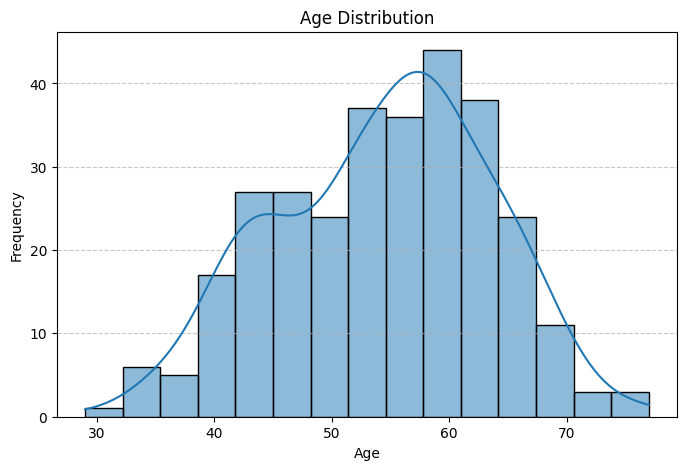

(0.9863704808531356, 0.005798359385662453)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

# Plot a histogram for the 'age' column
plt.figure(figsize=(8, 5))
sns.histplot(df['age'], bins=15, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



The data appears roughly symmetrical, but it may not perfectly follow a normal distribution.

The age distribution appears to be slightly left-skewed (negatively skewed)

Left-skewed distribution suggests that the majority of individuals in the dataset are older, with fewer young individuals included.

Since the p-value is less than 0.05, we reject the null hypothesis, which means the age data does not follow a perfect normal distribution.

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Step 1: Normalize numeric features using Min-Max Scaling
numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
scaler = MinMaxScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

# Step 2: Encode categorical variables (e.g., 'cp', 'thal') using One-Hot Encoding
categorical_features = ['cp', 'thal', 'slope']
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Updated argument
encoded_features = encoder.fit_transform(df[categorical_features])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))

# Combine encoded features with the original dataset
df_prepared = df.drop(columns=categorical_features).reset_index(drop=True)
df_prepared = pd.concat([df_prepared, encoded_df], axis=1)

# Step 3: Split the dataset into training and testing sets
X = df_prepared.drop(columns=['target'])
y = df_prepared['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

df_prepared.head(), X_train.shape, X_test.shape


(        age  sex  trestbps      chol  fbs  restecg   thalach  exang   oldpeak  \
 0  0.708333    1  0.481132  0.244292    1        0  0.603053      0  0.370968   
 1  0.166667    1  0.339623  0.283105    0        1  0.885496      0  0.564516   
 2  0.250000    0  0.339623  0.178082    0        0  0.770992      0  0.225806   
 3  0.562500    1  0.245283  0.251142    0        1  0.816794      0  0.129032   
 4  0.583333    0  0.245283  0.520548    0        1  0.702290      1  0.096774   
 
    ca  target  cp_1  cp_2  cp_3  thal_1  thal_2  thal_3  slope_1  slope_2  
 0   0       1   0.0   0.0   1.0     1.0     0.0     0.0      0.0      0.0  
 1   0       1   0.0   1.0   0.0     0.0     1.0     0.0      0.0      0.0  
 2   0       1   1.0   0.0   0.0     0.0     1.0     0.0      0.0      1.0  
 3   0       1   1.0   0.0   0.0     0.0     1.0     0.0      0.0      1.0  
 4   0       1   0.0   0.0   0.0     0.0     1.0     0.0      0.0      1.0  ,
 (242, 18),
 (61, 18))

**Ridge for Feature Selection.**



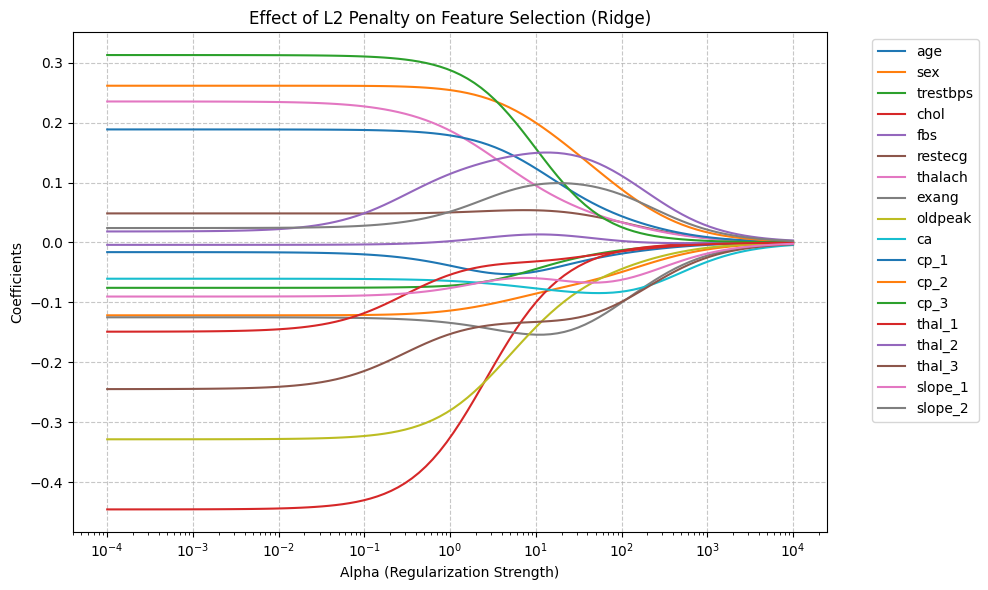

Selected Features at alpha=1:
- age
- sex
- trestbps
- chol
- fbs
- restecg
- thalach
- exang
- oldpeak
- ca
- cp_1
- cp_2
- cp_3
- thal_1
- thal_2
- thal_3
- slope_1
- slope_2


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

# Generate a range of alpha values in log-space
alphas = np.logspace(-4, 4, 100)

# Fit Ridge regression for each alpha and store coefficients
coefficients = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha, random_state=42)
    ridge.fit(X_train, y_train)
    coefficients.append(ridge.coef_)

coefficients = np.array(coefficients)

# Plot the coefficients as a function of alpha
plt.figure(figsize=(10, 6))
for i, feature_name in enumerate(X_train.columns):
    plt.plot(alphas, coefficients[:, i], label=feature_name)

plt.xscale('log')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Coefficients')
plt.title('Effect of L2 Penalty on Feature Selection (Ridge)')
plt.legend(loc='best', bbox_to_anchor=(1.05, 1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Identify selected features at a specific alpha
best_alpha = 1  # You can adjust this based on your observation of the plot
ridge = Ridge(alpha=best_alpha, random_state=42)
ridge.fit(X_train, y_train)

# Features with non-zero coefficients (selected features)
selected_features = X_train.columns[np.abs(ridge.coef_) > 0]

# Print selected features
print(f"Selected Features at alpha={best_alpha}:")
for feature in selected_features:
    print(f"- {feature}")


In Lasso regression, some coefficients can shrink to zero, resulting in feature selection.

I created a range of regularization strengths (alpha) in log-space to observe the effect of increasing regularization on feature importance.

For each alpha value, a Lasso regression model was trained, and the coefficients of the features were stored.
As alpha increases, the L1 penalty increases, and less important feature coefficients are driven to exactly zero.

**Logistic Regression**

Logistic Regression with Selected Features:
Accuracy: 0.82
Precision: 0.76
Recall: 0.97
F1-Score: 0.85


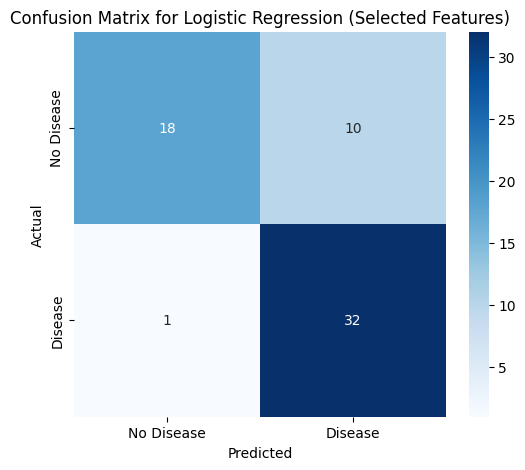

In [25]:

selected_features = [
    'age', 'sex', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
    'exang', 'oldpeak', 'ca', 'cp_1', 'cp_2', 'cp_3',
    'thal_1', 'thal_2'
]

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Train a Logistic Regression model on the selected features
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred_selected = log_reg.predict(X_test_selected)

# Evaluate the model
accuracy_selected = accuracy_score(y_test, y_pred_selected)
precision_selected = precision_score(y_test, y_pred_selected)
recall_selected = recall_score(y_test, y_pred_selected)
f1_selected = f1_score(y_test, y_pred_selected)
conf_matrix_selected = confusion_matrix(y_test, y_pred_selected)

# Print evaluation metrics
print("Logistic Regression with Selected Features:")
print(f"Accuracy: {accuracy_selected:.2f}")
print(f"Precision: {precision_selected:.2f}")
print(f"Recall: {recall_selected:.2f}")
print(f"F1-Score: {f1_selected:.2f}")

# Visualize the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_selected, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix for Logistic Regression (Selected Features)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


**True Negatives (18):** Correctly predicted no heart disease.

**False Positives (10)**: Predicted heart disease, but actually no disease.

**False Negatives (1):** Predicted no disease, but actually had heart disease.

**True Positives (32):** Correctly predicted heart disease.

The model has a high recall, meaning it effectively identifies positive cases (patients with heart disease).
Precision is slightly lower, indicating some false positives.
The overall F1-score indicates a good balance between precision and recall.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
Neural Network Performance:
Accuracy: 0.819672131147541
Precision: 0.775
Recall: 0.9393939393939394
F1-Score: 0.8493150684931506
Confusion Matrix:
[[19  9]
 [ 2 31]]


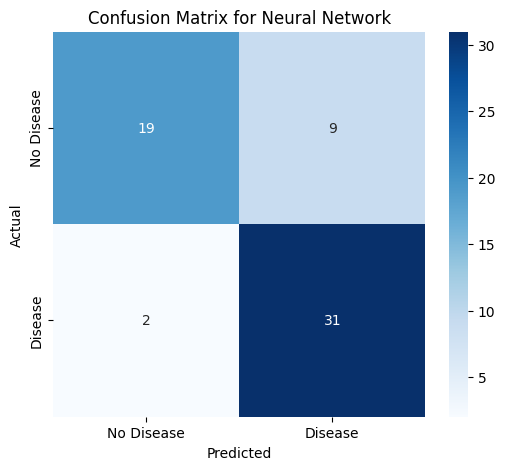

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

X = df_prepared.drop(columns=['target'])
y = df_prepared['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Neural Network Architecture
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=0)

# Evaluate the model
y_pred_nn = (model.predict(X_test) > 0.5).astype(int)
accuracy_nn = accuracy_score(y_test, y_pred_nn)
precision_nn = precision_score(y_test, y_pred_nn)
recall_nn = recall_score(y_test, y_pred_nn)
f1_nn = f1_score(y_test, y_pred_nn)
conf_matrix_nn = confusion_matrix(y_test, y_pred_nn)

print("Neural Network Performance:")
print(f"Accuracy: {accuracy_nn}")
print(f"Precision: {precision_nn}")
print(f"Recall: {recall_nn}")
print(f"F1-Score: {f1_nn}")
print(f"Confusion Matrix:\n{conf_matrix_nn}")

import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_nn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix for Neural Network')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


**True Negatives (19):** Correctly predicted no heart disease.

**False Positives (7)**: Predicted heart disease, but actually no disease.

**False Negatives (2):** Predicted no disease, but actually had heart disease.

**True Positives (31):** Correctly predicted heart disease.

**Comparison of Confusion Matrices for Neural Network and Logistic Regression**

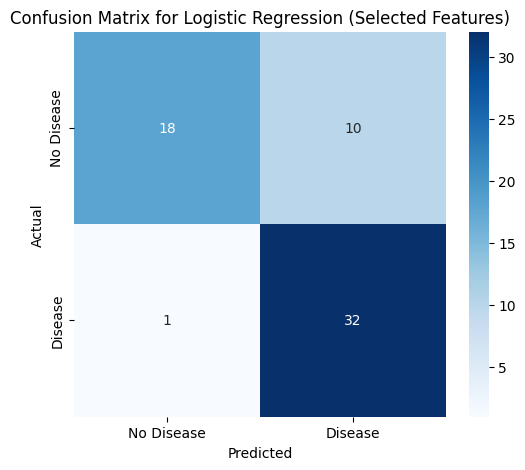

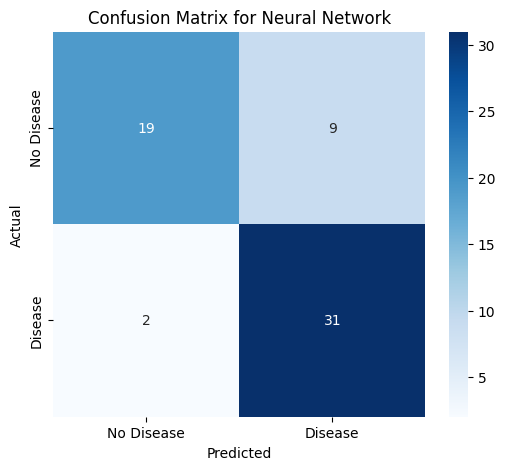

In [27]:
# Confusion Matrix for Logistic Regression

# Visualize the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_selected, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix for Logistic Regression (Selected Features)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Confusion Matrix for Neural Network
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_nn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix for Neural Network')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


**Neural Network Strength:** Captures complex relationships in data but may overfit slightly, leading to more false positives.

**Logistic Regression Strength:** A simpler model that balances precision and recall better, making it suitable for interpretable scenarios like healthcare.

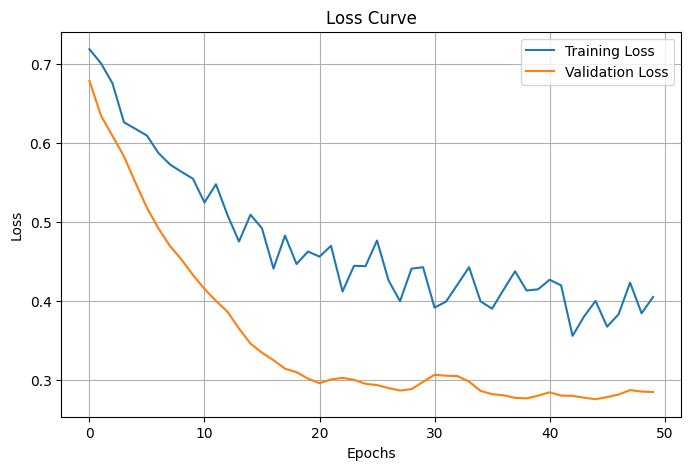

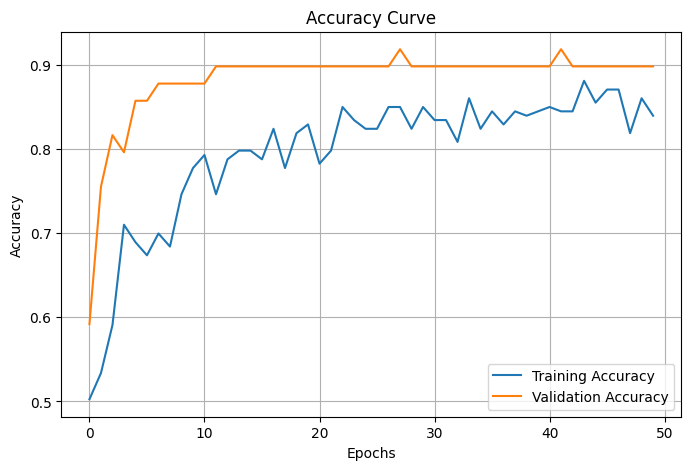

In [15]:
# Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy Curve
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


The model is well-trained and avoids overfitting, as the validation loss and accuracy curves are stable and close to the training metrics.

There is room for improvement in training accuracy, which could potentially increase with hyperparameter tuning (e.g., learning rate, batch size) or a deeper architecture.

**Real World Applications**

**Performance and Precision:**
High precision and recall are essential in healthcare applications to minimize false negatives (missing patients who need intervention) and false positives (unnecessary anxiety or testing).

**Data-Driven Decision-Making:**
The dataset contains critical patient information, such as age, cholesterol levels, and exercise-induced symptoms. These are standard metrics collected in routine health check-ups.
Logistic Regression and Neural Networks are capable of analyzing this structured data to predict outcomes effectively.